IE6600 Computation and Visualization for Analytics [Spring 2025]

Project 02: Traffic Violations

In [1]:
import pandas as pd
import numpy as np
import requests
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


#---Load the dataset---#
df = pd.read_csv("/content/Traffic_Violations (2).csv")
print("Dataset loaded successfully!")

<ipython-input-1-68250711a5a8>:11: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/Traffic_Violations (2).csv")


Dataset loaded successfully!


In [2]:
#---Check the First Few Rows---#

print("\nFirst 5 rows:")
df.head(5)


First 5 rows:


,SeqID,Date Of Stop,Time Of Stop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,...,Charge,Article,Contributed To Accident,Race,Gender,Driver City,Driver State,DL State,Arrest Type,Geolocation
0,52282e8c-f2e1-4bb5-8509-2d5e4f8da8ca,05/01/2023,23:11:00,MCP,"3rd District, Silver Spring",OPERATING UNREGISTERED MOTOR VEHICLE ON HIGHWAY,BRIGGS CHANEY RD @ COLUMIBA PIKE,0.000000,0.000000,No,...,13-401(b1),Transportation Article,False,WHITE,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)"
1,9be35886-e00c-49c2-8f27-2f6307696a17,11/25/2023,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,No,...,13-409(b),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)"
2,9be35886-e00c-49c2-8f27-2f6307696a17,11/25/2023,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,No,...,13-411(f),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)"
3,4d37fa99-0df3-4a56-9ba6-692bce894a34,11/26/2023,09:16:00,MCP,"4th District, Wheaton",DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,3803 WELLER RD,39.058378,-77.049652,No,...,21-902(a1i),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0583783333333, -77.0496516666667)"
4,3a723e9a-5dc0-4bc3-9bd9-4555d6ce0e49,11/25/2023,05:45:00,MCP,"4th District, Wheaton",RECKLESS DRIVING VEHICLE IN WANTON AND WILLFUL...,OLNEY LAYTONSVILLE RD @ FIELDCREST RD,0.000000,0.000000,No,...,21-901.1(a),Transportation Article,False,WHITE,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)"


In [3]:
# Data Acquisition and Inspection

print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nColumn Names:\n", df.columns.values)
numerical_cols = df.select_dtypes(include=['number'])
print("\nDescriptive Statistics for Numerical Columns:\n", numerical_cols.describe())

# Frequency Analysis
categorical_cols = ['Violation Type', 'Location', 'Time Of Stop', 'Date Of Stop']
for col in categorical_cols:
    if col in df.columns:
        print(f"\nFrequency of {col}:\n{df[col].value_counts(dropna=False)}")
    else:
        print(f"Column '{col}' not found in DataFrame.")
print("\nViolation Types by Location (first 10):\n", df.groupby('Location')['Violation Type'].value_counts().head(10))
print("\nValues in 'Contributed To Accident' column:\n", df['Contributed To Accident'].unique())
# Convert to boolean
df['Contributed To Accident'] = df['Contributed To Accident'].astype(str).str.lower().map({'true': True, 'false': False})
print("\nValues in 'Contributed To Accident' column after conversion:\n", df['Contributed To Accident'].unique())

Shape: (245965, 43)

Data Types:
 SeqID                       object
Date Of Stop                object
Time Of Stop                object
Agency                      object
SubAgency                   object
Description                 object
Location                    object
Latitude                   float64
Longitude                  float64
Accident                    object
Belts                       object
Personal Injury             object
Property Damage             object
Fatal                       object
Commercial License          object
HAZMAT                      object
Commercial Vehicle          object
Alcohol                     object
Work Zone                   object
Search Conducted            object
Search Disposition          object
Search Outcome              object
Search Reason               object
Search Reason For Stop      object
Search Type                 object
Search Arrest Reason        object
State                       object
VehicleType          

In [4]:
# Data Cleaning and Preparation
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].fillna(df[col].mode()[0])
            except KeyError:
                # Handle the case where there's no mode (all NaN or unique values)
                df[col] = df[col].fillna("Unknown")
        elif df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].mean())

# Remove Duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
df = df[~duplicates]
print(f"{num_duplicates} duplicate rows removed.")

df['Violation Type'] = df['Violation Type'].str.title()

# Data Type Conversion
df['Date Of Stop'] = pd.to_datetime(df['Date Of Stop'], errors='coerce')
df['Time Of Stop'] = pd.to_datetime(df['Time Of Stop'], format='%H:%M:%S', errors='coerce').dt.time

# Convert other relevant columns as needed
for col in ['Latitude', 'Longitude', 'Year']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns to boolean
for col in ['Accident', 'Belts', 'Personal Injury', 'Property Damage', 'Fatal', 'Commercial License', 'HAZMAT', 'Commercial Vehicle', 'Alcohol', 'Work Zone', 'Search Conducted']:
    df[col] = df[col].astype(str).str.lower().map({'true': True, 'false': False})

display(df.head())

<ipython-input-4-b3e6d8d3b479>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


307 duplicate rows removed.


,SeqID,Date Of Stop,Time Of Stop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,...,Charge,Article,Contributed To Accident,Race,Gender,Driver City,Driver State,DL State,Arrest Type,Geolocation
0,52282e8c-f2e1-4bb5-8509-2d5e4f8da8ca,2023-05-01,23:11:00,MCP,"3rd District, Silver Spring",OPERATING UNREGISTERED MOTOR VEHICLE ON HIGHWAY,BRIGGS CHANEY RD @ COLUMIBA PIKE,0.000000,0.000000,NaN,...,13-401(b1),Transportation Article,False,WHITE,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)"
1,9be35886-e00c-49c2-8f27-2f6307696a17,2023-11-25,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,NaN,...,13-409(b),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)"
2,9be35886-e00c-49c2-8f27-2f6307696a17,2023-11-25,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,NaN,...,13-411(f),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)"
3,4d37fa99-0df3-4a56-9ba6-692bce894a34,2023-11-26,09:16:00,MCP,"4th District, Wheaton",DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,3803 WELLER RD,39.058378,-77.049652,NaN,...,21-902(a1i),Transportation Article,False,HISPANIC,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0583783333333, -77.0496516666667)"
4,3a723e9a-5dc0-4bc3-9bd9-4555d6ce0e49,2023-11-25,05:45:00,MCP,"4th District, Wheaton",RECKLESS DRIVING VEHICLE IN WANTON AND WILLFUL...,OLNEY LAYTONSVILLE RD @ FIELDCREST RD,0.000000,0.000000,NaN,...,21-901.1(a),Transportation Article,False,WHITE,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)"


In [5]:
# Perform necessary data type conversions and normalizations

# Convert 'Date Of Stop' to datetime objects
df['Date Of Stop'] = pd.to_datetime(df['Date Of Stop'])

# Extract year, month, day of week, and hour
df['Year'] = df['Date Of Stop'].dt.year
df['Month'] = df['Date Of Stop'].dt.month
df['DayOfWeek'] = df['Date Of Stop'].dt.day_name()
df['Hour'] = df['Date Of Stop'].dt.hour
df['Time Of Stop'] = pd.to_datetime(df['Time Of Stop'], format='%H:%M:%S', errors='coerce').dt.time
df['Hour'] = df['Time Of Stop'].apply(lambda x: x.hour if x else None)
violations_by_hour = df.groupby('Hour')['Violation Type'].count().reset_index(name='ViolationCount')

# Create time of day categories
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

# Aggregate data
violations_by_month = df.groupby('Month')['Violation Type'].count().reset_index(name='ViolationCount')
violations_by_location = df.groupby('Location')['Violation Type'].count().reset_index(name='ViolationCount')
violations_by_timeofday = df.groupby('TimeOfDay')['Violation Type'].count().reset_index(name='ViolationCount')

# Convert relevant columns to categorical
categorical_cols = ['DayOfWeek', 'TimeOfDay', 'Violation Type', 'Month']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

display(df.head())
display(violations_by_month.head())
display(violations_by_location.head())
display(violations_by_timeofday.head())

,SeqID,Date Of Stop,Time Of Stop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,...,Gender,Driver City,Driver State,DL State,Arrest Type,Geolocation,Month,DayOfWeek,Hour,TimeOfDay
0,52282e8c-f2e1-4bb5-8509-2d5e4f8da8ca,2023-05-01,23:11:00,MCP,"3rd District, Silver Spring",OPERATING UNREGISTERED MOTOR VEHICLE ON HIGHWAY,BRIGGS CHANEY RD @ COLUMIBA PIKE,0.000000,0.000000,NaN,...,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)",5,Monday,23,Evening
1,9be35886-e00c-49c2-8f27-2f6307696a17,2023-11-25,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,NaN,...,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)",11,Saturday,0,Night
2,9be35886-e00c-49c2-8f27-2f6307696a17,2023-11-25,00:20:00,MCP,"6th District, Gaithersburg / Montgomery Village",DISPLAYING EXPIRED REGISTRATION PLATE ISSUED B...,GEORGIA AVE / WEISMAN RD,39.052962,-77.051304,NaN,...,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0529625, -77.0513041666667)",11,Saturday,0,Night
3,4d37fa99-0df3-4a56-9ba6-692bce894a34,2023-11-26,09:16:00,MCP,"4th District, Wheaton",DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,3803 WELLER RD,39.058378,-77.049652,NaN,...,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.0583783333333, -77.0496516666667)",11,Sunday,9,Morning
4,3a723e9a-5dc0-4bc3-9bd9-4555d6ce0e49,2023-11-25,05:45:00,MCP,"4th District, Wheaton",RECKLESS DRIVING VEHICLE IN WANTON AND WILLFUL...,OLNEY LAYTONSVILLE RD @ FIELDCREST RD,0.000000,0.000000,NaN,...,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(0.0, 0.0)",11,Saturday,5,Night


,Month,ViolationCount
0,1,20039
1,2,21203
2,3,19781
3,4,15442
4,5,23252


,Location,ViolationCount
0,#2 DEER PARK LANE,2
1,& STANFORD ST,1
2,( CLOPPER RD 7-11) 12861,1
3,(NB) 270,2
4,(NORTH)NEW HAMPSHIRE AVE/ CHALMERS,5


,TimeOfDay,ViolationCount
0,Afternoon,69073
1,Evening,70878
2,Morning,64430
3,Night,41277


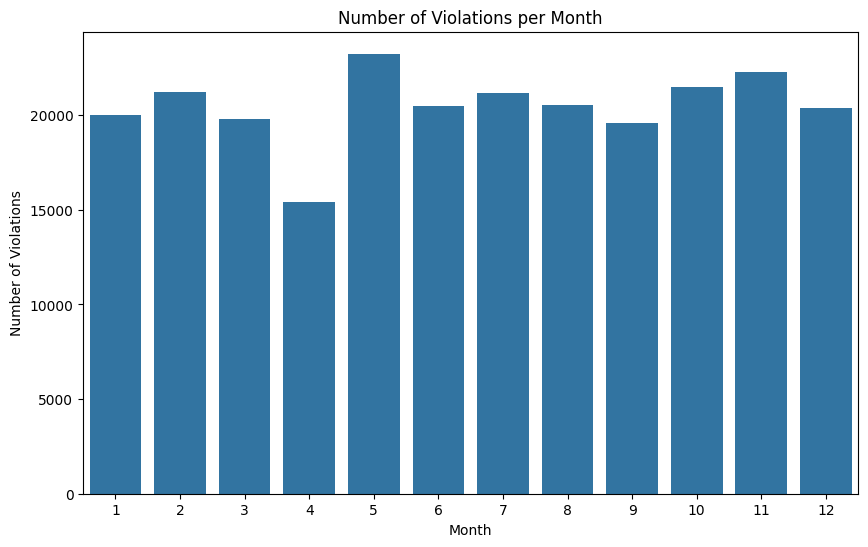

In [7]:
# Exploratory Data Analysis (EDA) Using Seaborn

# 1. Violations by Month
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='ViolationCount', data=violations_by_month)
plt.title('Number of Violations per Month')
plt.xlabel('Month')
plt.ylabel('Number of Violations')
plt.savefig('violations_by_month.png')
plt.show()



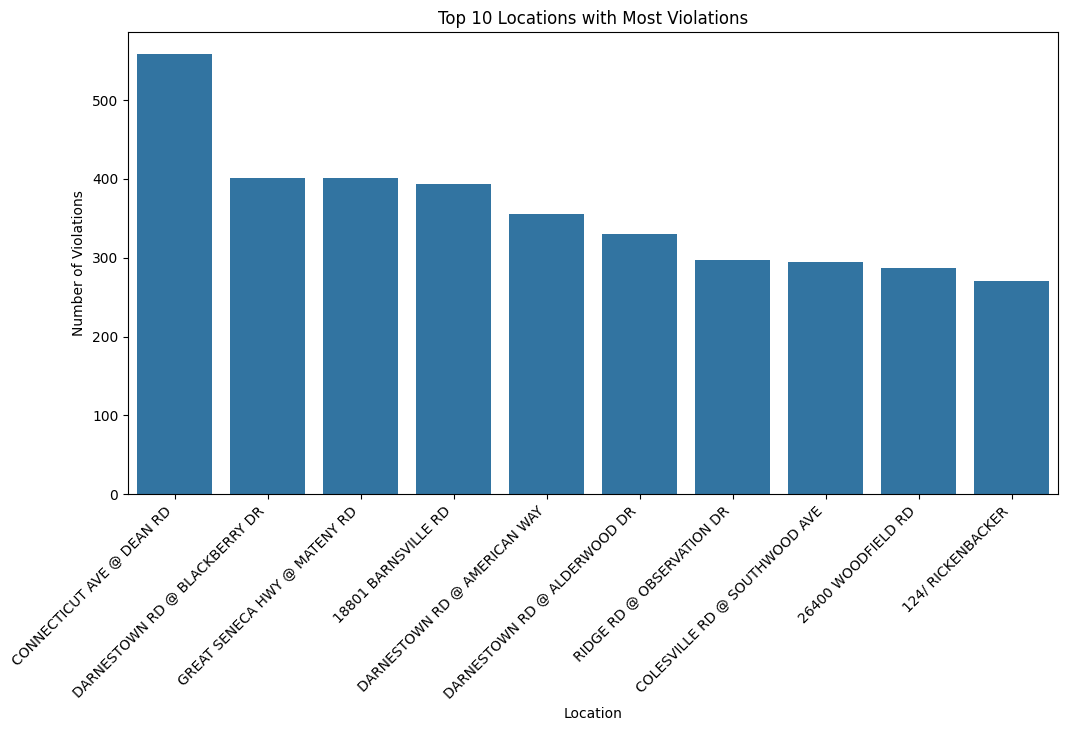

In [8]:
# 2. Violations by Location (Top 10)
top_10_locations = violations_by_location.nlargest(10, 'ViolationCount')
plt.figure(figsize=(12, 6))
sns.barplot(x='Location', y='ViolationCount', data=top_10_locations)
plt.title('Top 10 Locations with Most Violations')
plt.xlabel('Location')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45, ha='right')
plt.savefig('violations_by_location.png')
plt.show()


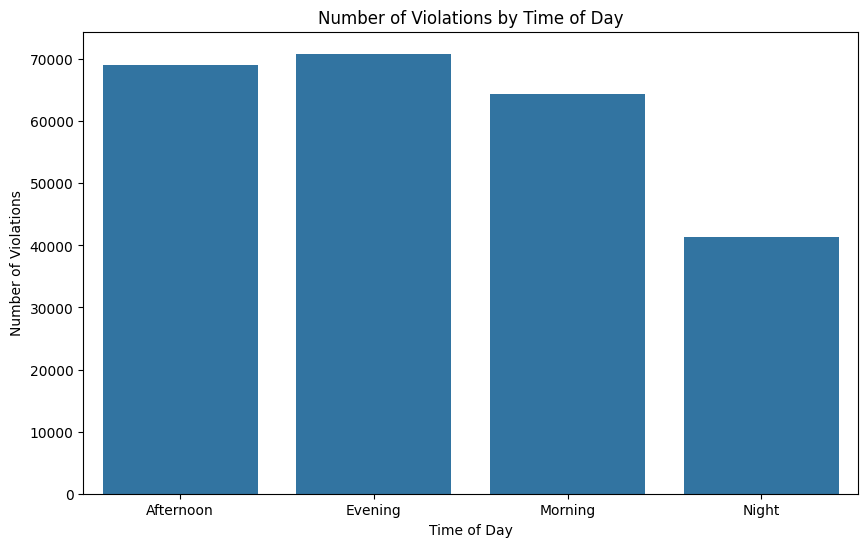

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x='TimeOfDay', y='ViolationCount', data=violations_by_timeofday)
plt.title('Number of Violations by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Violations')
plt.savefig('violations_by_timeofday.png')
plt.show()


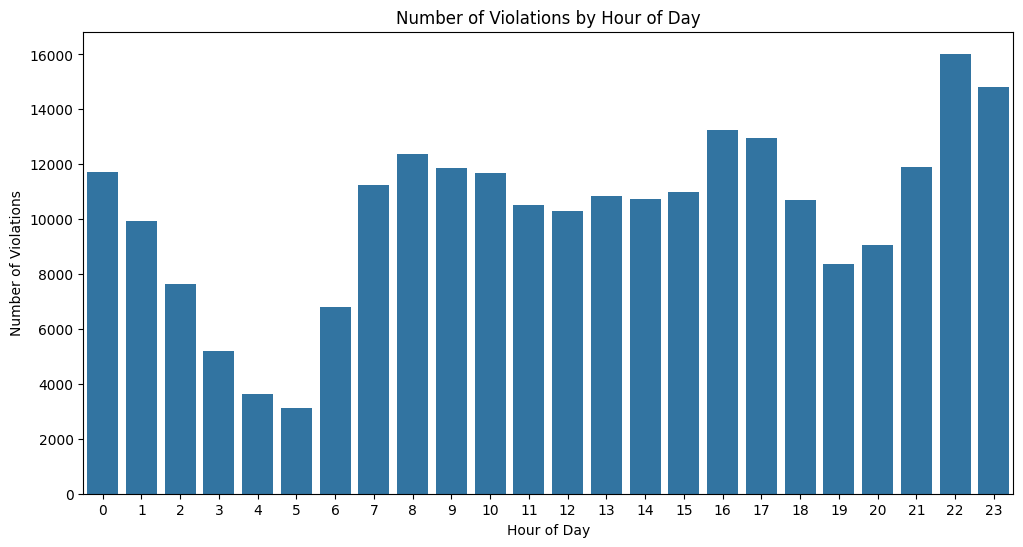

In [10]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='ViolationCount', data=violations_by_hour)
plt.title('Number of Violations by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Violations')
plt.savefig('violations_by_hour.png')
plt.show()

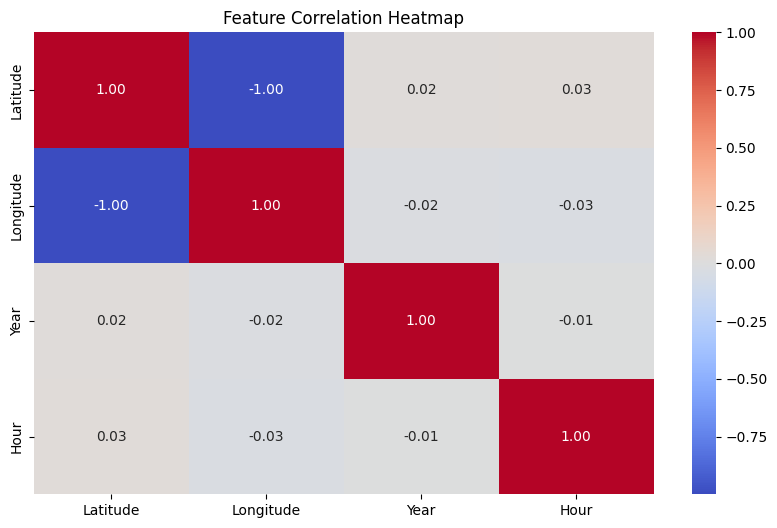

In [ ]:
# Correlation Analysis

numeric_df = df.select_dtypes(include=['number'])

# Check if there are any numeric columns
if not numeric_df.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.savefig("correlation_heatmap.png")
    plt.show()
else:
    print("No numeric columns available for correlation analysis.")


T-Test between 'Citation' and 'Warning':
t-statistic = -125.8674, p-value = 0.0000


<ipython-input-8-13dffb04c491>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[category_col], y=df[numeric_col], palette="coolwarm")


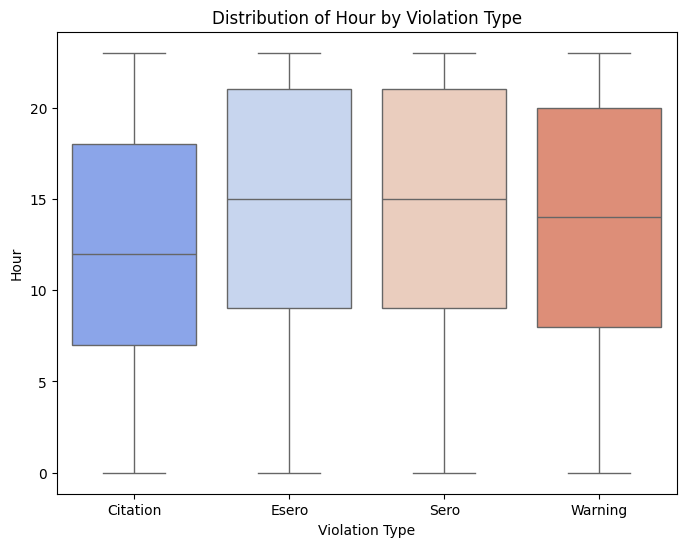

In [ ]:
# Hypothesis Testing
# Choosing a categorical and numeric column for comparison
category_col = "Violation Type"
numeric_col = "Hour"

if category_col in df.columns and numeric_col in df.columns:
    unique_values = df[category_col].dropna().unique()

    # Ensure at least two groups exist for comparison
    if len(unique_values) >= 2:
        group1 = df[df[category_col] == unique_values[0]][numeric_col].dropna()
        group2 = df[df[category_col] == unique_values[1]][numeric_col].dropna()

        # Perform T-Test
        t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')
        print(f"\nT-Test between '{unique_values[0]}' and '{unique_values[1]}':")
        print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

        # Boxplot to visualize distribution
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[category_col], y=df[numeric_col], palette="coolwarm")
        plt.title(f"Distribution of {numeric_col} by {category_col}")
        plt.savefig("violation_hour_boxplot.png")
        plt.show()
    else:
        print(f"Not enough unique values in '{category_col}' for hypothesis testing.")



In [ ]:
# Chi-Square Test
# Checking if categorical variables are dependent
cat1, cat2 = "Violation Type", "Race"

if cat1 in df.columns and cat2 in df.columns:
    contingency_table = pd.crosstab(df[cat1], df[cat2])

    # Perform Chi-Square Test
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"\nChi-Square Test between '{cat1}' and '{cat2}':")
    print(f"chi2-statistic = {chi2_stat:.4f}, p-value = {p_val:.4f}")


Chi-Square Test between 'Violation Type' and 'Race':
chi2-statistic = 23292.2161, p-value = 0.0000


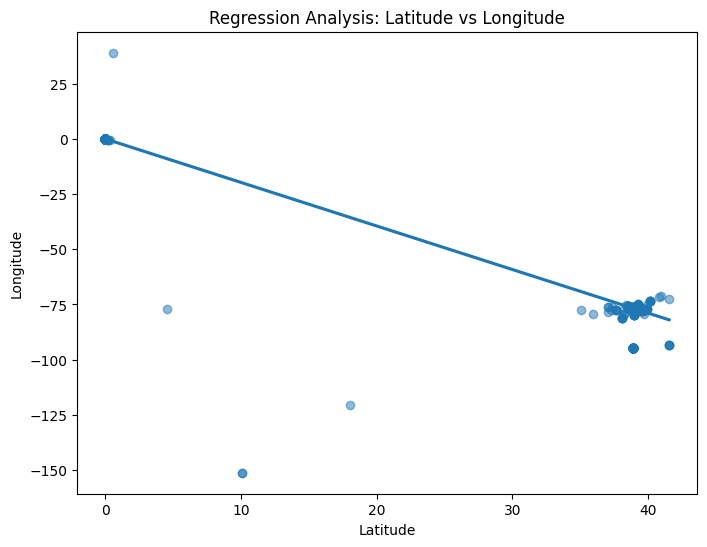


Pearson Correlation Coefficient between 'Latitude' and 'Longitude': -0.9999


In [ ]:
# Regression Analysis
# Checking correlation between two numerical variables
num1, num2 = "Latitude", "Longitude"

if num1 in df.columns and num2 in df.columns:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=df[num1], y=df[num2], scatter_kws={"alpha":0.5})
    plt.title(f"Regression Analysis: {num1} vs {num2}")
    plt.xlabel(num1)
    plt.ylabel(num2)
    plt.savefig("regression_plot.png")
    plt.show()

    # Calculate correlation coefficient
    corr_coef, _ = stats.pearsonr(df[num1].dropna(), df[num2].dropna())
    print(f"\nPearson Correlation Coefficient between '{num1}' and '{num2}': {corr_coef:.4f}")
